# 배경지식

- 산란일사량(DHI) : 대기중의 공기 분자나 부유 입자에 충돌하여 여러 방향으로 산란된 일사량

- 직달 일사량(DNI) : 대기중의 수증기나 작은 먼지에 흡수되지 않은 채로, 태양으로부터 직접 지표면에 도달하는 일사량이다. 이 떄에 지표면에서 태양과 직각인 면에 도달하는 일사량이다.
    - 직달 일사량은 날씨에 따라 강도가 다르다. 맑은날에는 보통 직달일사량이 전천일사량보다 크지만, 흐린날에는 직달 일사량이 매우 작고 전천일사량이 훨씬 크다.
    
- 전천 일사량(GHI) : 수평면에 입사하는 직달일사 및 산란 복사를 합친것을 말한다.

- GHI = DNI * COS천정각(90-태양의 고도)+산란일사량

- Hour - 시간
- Minute - 분
- DHI - 수평면 산란일사량(Diffuse Horizontal Irradiance (W/m2))
- DNI - 직달일사량(Direct Normal Irradiance (W/m2))
- WS - 풍속(Wind Speed (m/s))
- RH - 상대습도(Relative Humidity (%))
- T - 기온(Temperature (Degree C))
- Target - 태양광 발전량 (kW)


# 모델링 아이디어

- 회귀를 쓸 것이라면, 1일치로 나머지 2일치를 추정하는것이 좋아보인다. (태양광은 이전것의 결과가 심하게 누적되는 편이 아니다. Markov chain 처럼 이전의 값이 주어지면 그 전 값들과는 독립성을 띤다고 생각이 된다. )
- 하지만.. 어쩃든 그 이전에 대한 평균을 내 주어야 할 것 같다는 생각?
- 다만, 이전 3일치에 대한 가중평균을 해서, 최근 1일치의 값이 크게 반영되게 하는것이 좋아보인다. 
- 일 평균 기온을 쓴다면, 기온 -> 계절 -> 일조량 이라는 Measure 가 가능해보인다...!

# module, data import 

In [48]:
import pandas as pd
import numpy as np
import os
import glob
import random
import seaborn as sns
import math
import math

#import warnings
#warnings.filterwarnings("ignore")

In [49]:
# train 데이터 불러오기
train = pd.read_csv('./data/train/train.csv')

In [50]:
df_train = train.copy()

In [51]:
# train 데이터 살펴보기
df_train.head()

,Day,Hour,Minute,DHI,DNI,WS,RH,T,TARGET
0,0,0,0,0,0,1.5,69.08,-12,0.0
1,0,0,30,0,0,1.5,69.06,-12,0.0
2,0,1,0,0,0,1.6,71.78,-12,0.0
3,0,1,30,0,0,1.6,71.75,-12,0.0
4,0,2,0,0,0,1.6,75.20,-12,0.0


In [52]:
# 제출 데이터 불러오기
submission = pd.read_csv('./data/sample_submission.csv')

In [53]:
# 제출 데이터 살펴보기
submission.tail()

,id,q_0.1,q_0.2,q_0.3,q_0.4,q_0.5,q_0.6,q_0.7,q_0.8,q_0.9
7771,80.csv_Day8_21h30m,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7772,80.csv_Day8_22h00m,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7773,80.csv_Day8_22h30m,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7774,80.csv_Day8_23h00m,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7775,80.csv_Day8_23h30m,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# 데이터 살펴보기

In [54]:
df_train.shape

(52560, 9)

In [55]:
sum(df_train['RH'] == 100)/df_train.shape[0]

0.02332572298325723

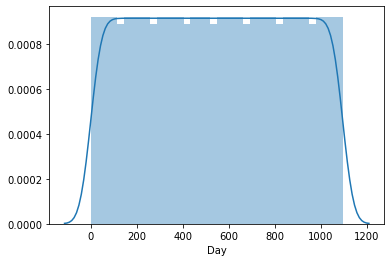

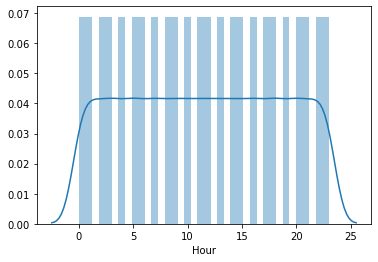

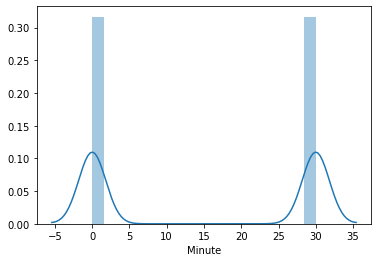

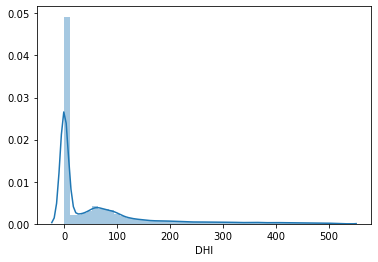

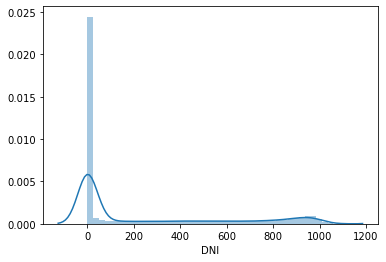

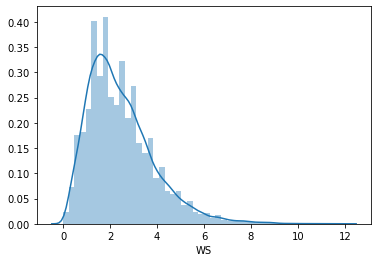

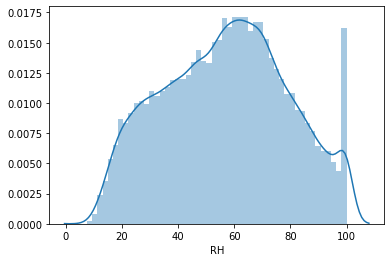

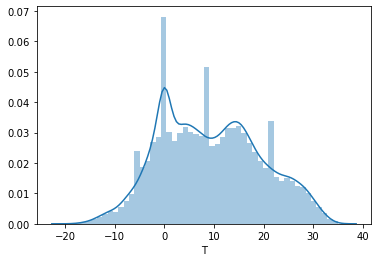

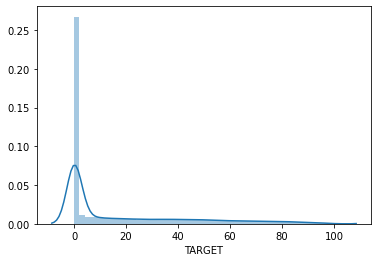

In [56]:
import seaborn as sns
import matplotlib.pyplot as plt
df=df_train
for i, col in enumerate(df.columns):
    plt.figure(i)
    sns.distplot(df[col])

In [57]:
# NA 가 없음
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52560 entries, 0 to 52559
Data columns (total 9 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Day     52560 non-null  int64  
 1   Hour    52560 non-null  int64  
 2   Minute  52560 non-null  int64  
 3   DHI     52560 non-null  int64  
 4   DNI     52560 non-null  int64  
 5   WS      52560 non-null  float64
 6   RH      52560 non-null  float64
 7   T       52560 non-null  int64  
 8   TARGET  52560 non-null  float64
dtypes: float64(3), int64(6)
memory usage: 3.6 MB


In [58]:
# 데이터의 type 은 잘 정의되어있다.(not categorical)
df_train.head()

,Day,Hour,Minute,DHI,DNI,WS,RH,T,TARGET
0,0,0,0,0,0,1.5,69.08,-12,0.0
1,0,0,30,0,0,1.5,69.06,-12,0.0
2,0,1,0,0,0,1.6,71.78,-12,0.0
3,0,1,30,0,0,1.6,71.75,-12,0.0
4,0,2,0,0,0,1.6,75.20,-12,0.0


# EDA

## Hour 분 더하기

In [59]:
def hour(df):
    df['Hour'] = df['Hour'] + df['Minute']/60
    return(df)

In [60]:
hour(df_train) 

,Day,Hour,Minute,DHI,DNI,WS,RH,T,TARGET
0,0,0.0,0,0,0,1.5,69.08,-12,0.0
1,0,0.5,30,0,0,1.5,69.06,-12,0.0
2,0,1.0,0,0,0,1.6,71.78,-12,0.0
3,0,1.5,30,0,0,1.6,71.75,-12,0.0
4,0,2.0,0,0,0,1.6,75.20,-12,0.0
...,...,...,...,...,...,...,...,...,...
52555,1094,21.5,30,0,0,2.4,70.70,-4,0.0
52556,1094,22.0,0,0,0,2.4,66.79,-4,0.0
52557,1094,22.5,30,0,0,2.2,66.78,-4,0.0
52558,1094,23.0,0,0,0,2.1,67.72,-4,0.0


## Sine 함수 넣기

- 시계열 모델이 아니라 회귀를 넣기 때문에, 일별로 반복되는 주기성을 나타내기 sine 함수를 적용했다.

In [61]:
def sin_day(df):
    df['Sin_Day'] = np.sin(2*(df['Hour']/24)*(np.pi))
    return(df)

In [62]:
sin_day(df_train)

,Day,Hour,Minute,DHI,DNI,WS,RH,T,TARGET,Sin_Day
0,0,0.0,0,0,0,1.5,69.08,-12,0.0,0.000000
1,0,0.5,30,0,0,1.5,69.06,-12,0.0,0.130526
2,0,1.0,0,0,0,1.6,71.78,-12,0.0,0.258819
3,0,1.5,30,0,0,1.6,71.75,-12,0.0,0.382683
4,0,2.0,0,0,0,1.6,75.20,-12,0.0,0.500000
...,...,...,...,...,...,...,...,...,...,...
52555,1094,21.5,30,0,0,2.4,70.70,-4,0.0,-0.608761
52556,1094,22.0,0,0,0,2.4,66.79,-4,0.0,-0.500000
52557,1094,22.5,30,0,0,2.2,66.78,-4,0.0,-0.382683
52558,1094,23.0,0,0,0,2.1,67.72,-4,0.0,-0.258819


## 일 평균 넣기

- 계절성을 나타내면, 그에 따른 일조량도 자연스럽게 알 수 있기 때문에 매우 유용한 정보이다.
- 쓸 수 잇는 데이터는 온도(T) 밖에 없기때문에, 이를 이용해 최대한 계절성을 나타내고 싶었다.
- 그러므로 일 평균을 넣게 된다면, 겨울의 경우 낮은 값, 여름의 경우 높은 값을 나타내어 어느정도 날마다의 일조량을 근사하는 값이 될 수 있을것이다.

In [63]:
def Daymean_T(df) :
    df['Daymean_T']= df['T'].groupby(df['Day']).transform('mean')
    return(df)

In [64]:
Daymean_T(df_train)

,Day,Hour,Minute,DHI,DNI,WS,RH,T,TARGET,Sin_Day,Daymean_T
0,0,0.0,0,0,0,1.5,69.08,-12,0.0,0.000000,-7.979167
1,0,0.5,30,0,0,1.5,69.06,-12,0.0,0.130526,-7.979167
2,0,1.0,0,0,0,1.6,71.78,-12,0.0,0.258819,-7.979167
3,0,1.5,30,0,0,1.6,71.75,-12,0.0,0.382683,-7.979167
4,0,2.0,0,0,0,1.6,75.20,-12,0.0,0.500000,-7.979167
...,...,...,...,...,...,...,...,...,...,...,...
52555,1094,21.5,30,0,0,2.4,70.70,-4,0.0,-0.608761,-2.708333
52556,1094,22.0,0,0,0,2.4,66.79,-4,0.0,-0.500000,-2.708333
52557,1094,22.5,30,0,0,2.2,66.78,-4,0.0,-0.382683,-2.708333
52558,1094,23.0,0,0,0,2.1,67.72,-4,0.0,-0.258819,-2.708333


## GHI 계산하기

- GHI = DNI * COS천정각(90-태양의 고도)+산란일사량 이다.
- 하루동안의 평균 온도를 통해, 3개의 계절로 구분하였다.(여름, 겨울, 봄,가을)
- 그리고 그를 이용해서 각각 한국의 8월15일(여름) 12월30일(겨울) 5월1일(봄,가을) 로 지정해서 다르게 변수를 추가하였다.
- 

- 다음과 같은 계산식으로 계산을 하였다.
- 이 때에 온도로 어느정도 예측이 가능하게 하고자, 계절로 적위를 추정해 보고자 하였다.
- 그 스케일은, 어느정도 빈도수가 보장되어야 하므로 평균 영하 10도 ~ 영상 25도 로 잡았다. 
- 이를 근거로 적위를 선형으로 추정하였다. 한국의 적위는 -23.5 ~ 23.5 로서 그에따라 식은 -10*a + b =-23.5 , 25*a + b = 23.5 이 되게 추정하려 하였다
- 35*a = 47 -> a = 47/35
- b = 23.5 - 25*47/35

## GHI 수식에서 온도 scale 의 근거

<AxesSubplot:xlabel='Daymean_T'>

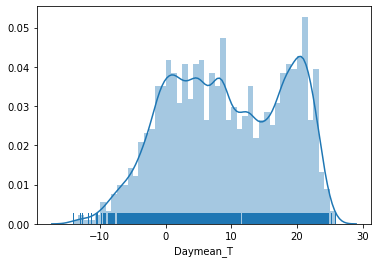

In [65]:
sns.distplot(df_train['Daymean_T'],kde=True, rug=True)

In [66]:
import math

In [67]:
# 태양의 적위 계산
# 한국은 위도 127도
# a : 적위 (봄과 가을의 경우인 0 으로 미리 설정하겠다.)
# b : 고도
# h = 시간

h = 12
rad = (math.pi/180) 
l = 37 * rad # 한국의 위도
a = 0 * rad # 적위
b = np.arcsin(math.sin(a)*math.sin(l) + math.cos(a)*math.cos(l)*math.cos((h*15-180)*(math.pi/180))) #b=


In [68]:
b*180/math.pi

53.0

In [69]:
def GHI(df):
    h = df['Hour']
    rad = math.pi/180
    l = 37 * rad # 한국의 위도
    alpha = 47/35 # 온도를 이용해 적위를 근사하기 위한 계수
    beta = 23.5-(25*47/35) # 온도를 이용해 적위를 근사하기 위한 계수 2
    a = (alpha*df['Daymean_T'] + beta) * rad # 선형으로 적위를 근사
    b = np.arcsin(np.sin(a)*np.sin(l) + np.cos(a)*np.cos(l)*np.cos((h*15-180)*(np.pi/180))) # b는 태양의 고도
    df['GHI']= df['DNI'] * np.cos((np.pi/2)-b) + df['DHI'] # GHI 계산식
    return(df) 

In [70]:
GHI(df_train)

,Day,Hour,Minute,DHI,DNI,WS,RH,T,TARGET,Sin_Day,Daymean_T,GHI
0,0,0.0,0,0,0,1.5,69.08,-12,0.0,0.000000,-7.979167,0.0
1,0,0.5,30,0,0,1.5,69.06,-12,0.0,0.130526,-7.979167,0.0
2,0,1.0,0,0,0,1.6,71.78,-12,0.0,0.258819,-7.979167,0.0
3,0,1.5,30,0,0,1.6,71.75,-12,0.0,0.382683,-7.979167,0.0
4,0,2.0,0,0,0,1.6,75.20,-12,0.0,0.500000,-7.979167,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
52555,1094,21.5,30,0,0,2.4,70.70,-4,0.0,-0.608761,-2.708333,0.0
52556,1094,22.0,0,0,0,2.4,66.79,-4,0.0,-0.500000,-2.708333,0.0
52557,1094,22.5,30,0,0,2.2,66.78,-4,0.0,-0.382683,-2.708333,0.0
52558,1094,23.0,0,0,0,2.1,67.72,-4,0.0,-0.258819,-2.708333,0.0


In [71]:
df_train.head(n=30)

,Day,Hour,Minute,DHI,DNI,WS,RH,T,TARGET,Sin_Day,Daymean_T,GHI
0,0,0.0,0,0,0,1.5,69.08,-12,0.000000,0.000000e+00,-7.979167,0.000000
1,0,0.5,30,0,0,1.5,69.06,-12,0.000000,1.305262e-01,-7.979167,0.000000
2,0,1.0,0,0,0,1.6,71.78,-12,0.000000,2.588190e-01,-7.979167,0.000000
3,0,1.5,30,0,0,1.6,71.75,-12,0.000000,3.826834e-01,-7.979167,0.000000
4,0,2.0,0,0,0,1.6,75.20,-12,0.000000,5.000000e-01,-7.979167,0.000000
5,0,2.5,30,0,0,1.5,69.29,-11,0.000000,6.087614e-01,-7.979167,0.000000
6,0,3.0,0,0,0,1.5,72.56,-11,0.000000,7.071068e-01,-7.979167,0.000000
7,0,3.5,30,0,0,1.4,72.55,-11,0.000000,7.933533e-01,-7.979167,0.000000
8,0,4.0,0,0,0,1.3,74.62,-11,0.000000,8.660254e-01,-7.979167,0.000000
9,0,4.5,30,0,0,1.3,74.61,-11,0.000000,9.238795e-01,-7.979167,0.000000


In [72]:
Col = df_train['GHI']>0

In [73]:
df_train[Col]

,Day,Hour,Minute,DHI,DNI,WS,RH,T,TARGET,Sin_Day,Daymean_T,GHI
16,0,8.0,0,29,494,1.8,65.45,-9,7.039287,0.866025,-7.979167,107.917533
17,0,8.5,30,61,7,1.9,55.90,-7,5.912871,0.793353,-7.979167,62.686714
18,0,9.0,0,58,743,2.1,57.39,-6,22.337268,0.707107,-7.979167,291.590978
19,0,9.5,30,67,811,1.9,53.15,-4,29.469529,0.608761,-7.979167,374.194766
20,0,10.0,0,138,368,1.8,55.99,-3,25.339762,0.500000,-7.979167,297.360912
...,...,...,...,...,...,...,...,...,...,...,...,...
52541,1094,14.5,30,93,538,2.9,43.02,0,24.869688,-0.608761,-2.708333,347.438515
52542,1094,15.0,0,73,516,2.8,46.51,0,19.426511,-0.707107,-2.708333,282.504532
52543,1094,15.5,30,37,756,2.4,50.11,-2,17.080689,-0.793353,-2.708333,286.262078
52544,1094,16.0,0,28,607,2.0,59.31,-4,9.197496,-0.866025,-2.708333,176.912434


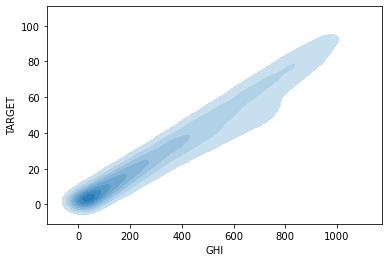

In [74]:
# 그에 따라 PLOT 을 그려본 결과 관계가 매우 뚜렷함을 알 수 있다.
ax = sns.kdeplot(data=df_train[Col]['GHI'],data2=df_train[Col]['TARGET'],shade=True,shade_lowest=False)

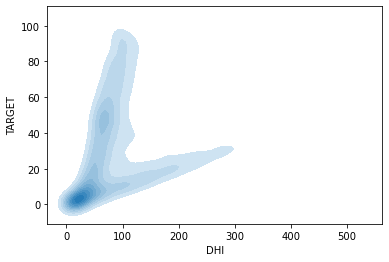

In [75]:
# 다른것들보다 훨씬 우수하다.
ax = sns.kdeplot(data=df_train[Col]['DHI'],data2=df_train[Col]['TARGET'],shade=True,shade_lowest=False)

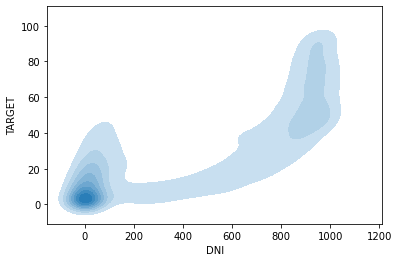

In [76]:
# 이 경우에도 마찬가지
ax = sns.kdeplot(data=df_train[Col]['DNI'],data2=df_train[Col]['TARGET'],shade=True,shade_lowest=False)

In [77]:
go = df_train[Col]['DNI'] + df_train[Col]['DHI'] 

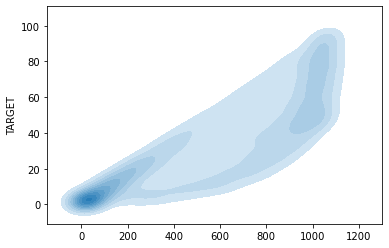

In [78]:
# 둘을 더했을 떄의 경우에도 마찬가지였다.
ax = sns.kdeplot(data=go,data2=df_train[Col]['TARGET'],shade=True,shade_lowest=False)

## train : Day,Minute 삭제하기

In [79]:
df_train.drop(columns = ['Day','Minute'],inplace=True)

## train 1일후, 2일후 Target 추가

In [80]:
df_train['y_1day'] = df_train['TARGET'].shift(-48).fillna(method='ffill') # 48 단계 후의 값들을 불러온다. (1일 후의 값들)

In [81]:
df_train['y_2day'] = df_train['TARGET'].shift(-96).fillna(method='ffill') # 96 단계 후의의 값들을 불러온다. (2일 후의 값들)

In [82]:
df_train = df_train.iloc[:-96] # 맨 뒤 2일동안의 데이터는 예측할 true 값들이 없기때문에 의미가 없다. 즉 삭제

In [83]:
df_train

,Hour,DHI,DNI,WS,RH,T,TARGET,Sin_Day,Daymean_T,GHI,y_1day,y_2day
0,0.0,0,0,1.5,69.08,-12,0.0,0.000000,-7.979167,0.0,0.0,0.0
1,0.5,0,0,1.5,69.06,-12,0.0,0.130526,-7.979167,0.0,0.0,0.0
2,1.0,0,0,1.6,71.78,-12,0.0,0.258819,-7.979167,0.0,0.0,0.0
3,1.5,0,0,1.6,71.75,-12,0.0,0.382683,-7.979167,0.0,0.0,0.0
4,2.0,0,0,1.6,75.20,-12,0.0,0.500000,-7.979167,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
52459,21.5,0,0,3.5,55.97,-1,0.0,-0.608761,2.187500,0.0,0.0,0.0
52460,22.0,0,0,3.9,54.23,-2,0.0,-0.500000,2.187500,0.0,0.0,0.0
52461,22.5,0,0,4.1,54.21,-2,0.0,-0.382683,2.187500,0.0,0.0,0.0
52462,23.0,0,0,4.3,56.46,-2,0.0,-0.258819,2.187500,0.0,0.0,0.0


## Test set 에 같은것 적용하기

In [84]:
def preprocess_Test(df):
    temp = df.copy() # copy 를 떠야 에러가 안난다.
    temp = temp[['Day','Hour','Minute', 'DHI', 'DNI', 'WS', 'RH', 'T','TARGET']]
    hour(temp)
    sin_day(temp)
    Daymean_T(temp)
    GHI(temp)
    return temp.iloc[-48:, :] 
# 이 때에 -48 로서 1일치만 가져온다는 뜻
# 왜냐하면, 위 모델의 경우 회귀가 단지 이전의 1일차의 값만 가지고 그 뒤 1,2일차의 예측을 하게 되기 떄문이다.

In [85]:
df_test = []
for i in range(81):
    file_path = './data/test/' + str(i) + '.csv'
    temp = pd.read_csv(file_path)
    temp = preprocess_Test(temp)
    df_test.append(temp) # 계속 append 해서 붙여준다.

In [86]:
df_test

[     Day  Hour  Minute  DHI  DNI   WS     RH    T     TARGET       Sin_Day  \
 288    6   0.0       0    0    0  0.8  80.92 -2.8   0.000000  0.000000e+00   
 289    6   0.5      30    0    0  0.9  81.53 -2.9   0.000000  1.305262e-01   
 290    6   1.0       0    0    0  1.0  79.91 -3.0   0.000000  2.588190e-01   
 291    6   1.5      30    0    0  0.9  79.91 -3.0   0.000000  3.826834e-01   
 292    6   2.0       0    0    0  0.9  77.20 -3.0   0.000000  5.000000e-01   
 293    6   2.5      30    0    0  1.1  78.36 -3.2   0.000000  6.087614e-01   
 294    6   3.0       0    0    0  1.2  76.78 -3.4   0.000000  7.071068e-01   
 295    6   3.5      30    0    0  1.8  77.93 -3.6   0.000000  7.933533e-01   
 296    6   4.0       0    0    0  2.4  76.89 -3.8   0.000000  8.660254e-01   
 297    6   4.5      30    0    0  2.9  78.64 -4.1   0.000000  9.238795e-01   
 298    6   5.0       0    0    0  3.5  77.21 -4.3   0.000000  9.659258e-01   
 299    6   5.5      30    0    0  3.6  79.07 -4.6  

In [87]:
X_test = pd.concat(df_test)
X_test.shape

(3888, 12)

## Test set 에도 Day 삭제 

In [89]:
X_test.drop(columns = ['Day','Minute'],inplace=True)

In [90]:
df_train

,Hour,DHI,DNI,WS,RH,T,TARGET,Sin_Day,Daymean_T,GHI,y_1day,y_2day
0,0.0,0,0,1.5,69.08,-12,0.0,0.000000,-7.979167,0.0,0.0,0.0
1,0.5,0,0,1.5,69.06,-12,0.0,0.130526,-7.979167,0.0,0.0,0.0
2,1.0,0,0,1.6,71.78,-12,0.0,0.258819,-7.979167,0.0,0.0,0.0
3,1.5,0,0,1.6,71.75,-12,0.0,0.382683,-7.979167,0.0,0.0,0.0
4,2.0,0,0,1.6,75.20,-12,0.0,0.500000,-7.979167,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
52459,21.5,0,0,3.5,55.97,-1,0.0,-0.608761,2.187500,0.0,0.0,0.0
52460,22.0,0,0,3.9,54.23,-2,0.0,-0.500000,2.187500,0.0,0.0,0.0
52461,22.5,0,0,4.1,54.21,-2,0.0,-0.382683,2.187500,0.0,0.0,0.0
52462,23.0,0,0,4.3,56.46,-2,0.0,-0.258819,2.187500,0.0,0.0,0.0


In [91]:
X_test

,Hour,DHI,DNI,WS,RH,T,TARGET,Sin_Day,Daymean_T,GHI
288,0.0,0,0,0.8,80.92,-2.8,0.0,0.000000,-5.487500,0.0
289,0.5,0,0,0.9,81.53,-2.9,0.0,0.130526,-5.487500,0.0
290,1.0,0,0,1.0,79.91,-3.0,0.0,0.258819,-5.487500,0.0
291,1.5,0,0,0.9,79.91,-3.0,0.0,0.382683,-5.487500,0.0
292,2.0,0,0,0.9,77.20,-3.0,0.0,0.500000,-5.487500,0.0
...,...,...,...,...,...,...,...,...,...,...
331,21.5,0,0,0.8,63.35,13.7,0.0,-0.608761,18.154167,0.0
332,22.0,0,0,0.7,64.82,13.1,0.0,-0.500000,18.154167,0.0
333,22.5,0,0,0.7,66.10,12.8,0.0,-0.382683,18.154167,0.0
334,23.0,0,0,0.6,67.64,12.4,0.0,-0.258819,18.154167,0.0


# Train

In [92]:
# 이 떄에 주 계획은 오늘 데이터로 1일후, 2일 후 데이터를 둘다 근사시키겠다는 뜻 이다.
from sklearn.model_selection import train_test_split
# 1일 후의 값을 예측시키기 위해 
X_train_1, X_valid_1, Y_train_1, Y_valid_1 = train_test_split(df_train.iloc[:, :-2], df_train.iloc[:, -2], test_size=0.3, random_state=0)
# 2일 후의 값을 예측시키기 위함
X_train_2, X_valid_2, Y_train_2, Y_valid_2 = train_test_split(df_train.iloc[:, :-2], df_train.iloc[:, -1], test_size=0.3, random_state=0)

## 잘 나누어졌는지 살펴보기

In [93]:
X_train_1.head()

,Hour,DHI,DNI,WS,RH,T,TARGET,Sin_Day,Daymean_T,GHI
32908,14.0,19,0,2.3,63.64,3,1.783051,-0.500000,0.937500,19.000000
10140,6.0,45,473,1.8,66.74,19,12.103848,1.000000,21.208333,134.891468
32182,11.0,77,929,2.2,39.56,13,56.300682,0.258819,7.479167,793.378582
20953,12.5,310,525,1.5,23.71,15,65.401188,-0.130526,7.750000,727.540736
36079,15.5,70,536,0.5,46.63,0,19.614206,-0.793353,-1.979167,253.110384


In [96]:
X_train_2.head()

,Hour,DHI,DNI,WS,RH,T,TARGET,Sin_Day,Daymean_T,GHI
32908,14.0,19,0,2.3,63.64,3,1.783051,-0.500000,0.937500,19.000000
10140,6.0,45,473,1.8,66.74,19,12.103848,1.000000,21.208333,134.891468
32182,11.0,77,929,2.2,39.56,13,56.300682,0.258819,7.479167,793.378582
20953,12.5,310,525,1.5,23.71,15,65.401188,-0.130526,7.750000,727.540736
36079,15.5,70,536,0.5,46.63,0,19.614206,-0.793353,-1.979167,253.110384


In [97]:
X_test.head()

,Hour,DHI,DNI,WS,RH,T,TARGET,Sin_Day,Daymean_T,GHI
288,0.0,0,0,0.8,80.92,-2.8,0.0,0.000000,-5.4875,0.0
289,0.5,0,0,0.9,81.53,-2.9,0.0,0.130526,-5.4875,0.0
290,1.0,0,0,1.0,79.91,-3.0,0.0,0.258819,-5.4875,0.0
291,1.5,0,0,0.9,79.91,-3.0,0.0,0.382683,-5.4875,0.0
292,2.0,0,0,0.9,77.20,-3.0,0.0,0.500000,-5.4875,0.0


In [98]:
quantiles = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]

In [99]:
from lightgbm import LGBMRegressor

# Get the model and the predictions in (a) - (b)
def LGBM(q, X_train, Y_train, X_valid, Y_valid, X_test):
    
    # (a) Modeling  
    model = LGBMRegressor(objective='quantile', # quantile regression 으로서 0.1 ~ 0.9 의 값을 체크한다.
                          alpha=q, # alpha 에 q 를 넣게되면 추정을 quantile 로 해준다.
                          n_estimators=10000,
                          bagging_fraction=0.7,
                          learning_rate=0.027, 
                          subsample=0.7)                   
    model.fit(X_train, Y_train, eval_metric = ['quantile'], 
          eval_set=[(X_valid, Y_valid)], early_stopping_rounds=300, verbose=500)

    # (b) Predictions
    pred = pd.Series(model.predict(X_test).round(2))
    return pred, model

In [100]:
# Target 예측

def train_data(X_train, Y_train, X_valid, Y_valid, X_test):

    LGBM_models=[]
    LGBM_actual_pred = pd.DataFrame()

    for q in quantiles:
        print(q)
        pred , model = LGBM(q, X_train, Y_train, X_valid, Y_valid, X_test)
        LGBM_models.append(model)
        LGBM_actual_pred = pd.concat([LGBM_actual_pred,pred],axis=1)

    LGBM_actual_pred.columns=quantiles
    
    return LGBM_models, LGBM_actual_pred

In [101]:
# Target1
# Target1 은 하루 후의 데이터 예측이다.
models_1, results_1 = train_data(X_train_1, Y_train_1, X_valid_1, Y_valid_1, X_test)
results_1.sort_index()[:48]

0.1
Training until validation scores don't improve for 300 rounds
[500]	valid_0's quantile: 1.33939
[1000]	valid_0's quantile: 1.33378
[1500]	valid_0's quantile: 1.3334
Early stopping, best iteration is:
[1614]	valid_0's quantile: 1.33229
0.2
Training until validation scores don't improve for 300 rounds
[500]	valid_0's quantile: 2.1043
[1000]	valid_0's quantile: 2.0672
[1500]	valid_0's quantile: 2.04789
[2000]	valid_0's quantile: 2.04113
[2500]	valid_0's quantile: 2.03641
[3000]	valid_0's quantile: 2.0338
[3500]	valid_0's quantile: 2.02768
[4000]	valid_0's quantile: 2.02273
[4500]	valid_0's quantile: 2.01824
[5000]	valid_0's quantile: 2.01468
[5500]	valid_0's quantile: 2.01215
[6000]	valid_0's quantile: 2.0105
Early stopping, best iteration is:
[5995]	valid_0's quantile: 2.0104
0.3
Training until validation scores don't improve for 300 rounds
[500]	valid_0's quantile: 2.47585
[1000]	valid_0's quantile: 2.44118
[1500]	valid_0's quantile: 2.41801
[2000]	valid_0's quantile: 2.39374
[2500]

,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9
0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
1,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
2,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
3,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
4,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
5,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
6,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
7,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
8,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
9,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00


In [102]:
# Target2
# Target2 는 이틀 뒤의 데이터 예측이다.
models_2, results_2 = train_data(X_train_2, Y_train_2, X_valid_2, Y_valid_2, X_test)
results_2.sort_index()[:48]

0.1
Training until validation scores don't improve for 300 rounds
[500]	valid_0's quantile: 1.34784
[1000]	valid_0's quantile: 1.3337
[1500]	valid_0's quantile: 1.33347
Early stopping, best iteration is:
[1440]	valid_0's quantile: 1.32967
0.2
Training until validation scores don't improve for 300 rounds
[500]	valid_0's quantile: 2.08375
[1000]	valid_0's quantile: 2.0416
[1500]	valid_0's quantile: 2.02312
[2000]	valid_0's quantile: 2.02097
[2500]	valid_0's quantile: 2.00126
[3000]	valid_0's quantile: 1.98803
[3500]	valid_0's quantile: 1.98141
[4000]	valid_0's quantile: 1.97796
[4500]	valid_0's quantile: 1.97466
Early stopping, best iteration is:
[4582]	valid_0's quantile: 1.97398
0.3
Training until validation scores don't improve for 300 rounds
[500]	valid_0's quantile: 2.4662
[1000]	valid_0's quantile: 2.40482
[1500]	valid_0's quantile: 2.39413
[2000]	valid_0's quantile: 2.37791
[2500]	valid_0's quantile: 2.36383
[3000]	valid_0's quantile: 2.34923
[3500]	valid_0's quantile: 2.33417
[40

,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9
0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
1,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
2,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
3,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
4,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
5,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
6,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
7,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
8,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
9,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00


In [103]:
results_1.sort_index().iloc[:48]

,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9
0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
1,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
2,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
3,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
4,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
5,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
6,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
7,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
8,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
9,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00


In [104]:
results_2.sort_index()

,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...
3883,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3884,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3885,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3886,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [105]:
print(results_1.shape, results_2.shape)

(3888, 9) (3888, 9)


In [106]:
submission.loc[submission.id.str.contains("Day7"), "q_0.1":] = results_1.sort_index().values
submission.loc[submission.id.str.contains("Day8"), "q_0.1":] = results_2.sort_index().values
submission

,id,q_0.1,q_0.2,q_0.3,q_0.4,q_0.5,q_0.6,q_0.7,q_0.8,q_0.9
0,0.csv_Day7_0h00m,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.csv_Day7_0h30m,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.csv_Day7_1h00m,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.csv_Day7_1h30m,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.csv_Day7_2h00m,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...
7771,80.csv_Day8_21h30m,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7772,80.csv_Day8_22h00m,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7773,80.csv_Day8_22h30m,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7774,80.csv_Day8_23h00m,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [107]:
submission.iloc[:48]

,id,q_0.1,q_0.2,q_0.3,q_0.4,q_0.5,q_0.6,q_0.7,q_0.8,q_0.9
0,0.csv_Day7_0h00m,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
1,0.csv_Day7_0h30m,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
2,0.csv_Day7_1h00m,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
3,0.csv_Day7_1h30m,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
4,0.csv_Day7_2h00m,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
5,0.csv_Day7_2h30m,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
6,0.csv_Day7_3h00m,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
7,0.csv_Day7_3h30m,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
8,0.csv_Day7_4h00m,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
9,0.csv_Day7_4h30m,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00


In [108]:
submission.iloc[48:96]

,id,q_0.1,q_0.2,q_0.3,q_0.4,q_0.5,q_0.6,q_0.7,q_0.8,q_0.9
48,0.csv_Day8_0h00m,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
49,0.csv_Day8_0h30m,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
50,0.csv_Day8_1h00m,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
51,0.csv_Day8_1h30m,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
52,0.csv_Day8_2h00m,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
53,0.csv_Day8_2h30m,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
54,0.csv_Day8_3h00m,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
55,0.csv_Day8_3h30m,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
56,0.csv_Day8_4h00m,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
57,0.csv_Day8_4h30m,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00


In [109]:
submission.to_csv('./data/hanadool-submission2.csv', index=False)